In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from PIL import Image  # Import Image module
from natsort import natsorted  # Natural sorting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split  # ✅ Correcte functie importeren
import matplotlib.pyplot as plt
from natsort import natsorted
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from natsort import natsorted

# Opdracht 1: Huizen prijs voorspellen
### Groep: Wolfs of Real Estate

Louis Brouwer (20196122)
Shanil Vilhena Alho (18086837)
Jordan van Sintanneland (23027711)
Mattias Aareleid (23103280)

# 1. EDA

In [3]:
# image folder aanmaken
image_folder = r"C:\Users\Shanil\Desktop\DL I\Train"

# afbeeldingen sorteren
image_files = natsorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

# df aanmaken
df = pd.DataFrame({"image_name": image_files})
df["image_path"] = df["image_name"].apply(lambda x: os.path.join(image_folder, x))

We zullen de eerste 5 afbeeldingen weergeven

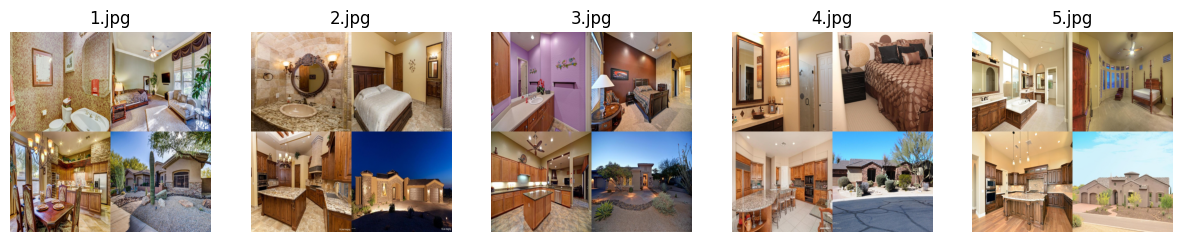

In [4]:
# Toon de eerste 5 afbeeldingen
plt.figure(figsize=(15, 5))

for i in range(5):
    img_path = df["image_path"].iloc[i]  
    img = cv2.imread(img_path)

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)  
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
    else:
        print(f"Afbeelding kan niet worden geladen: {img_path}")

plt.show()

# 1.2 Dataframe maken van de tabular data en korte EDA uitvoeren:

In [6]:
df = pd.read_csv(r"C:\Users\Shanil\Desktop\DL I\Train.csv")

Hieronder weergeven wij de eerste 5 rijen van de dataframe:

In [7]:
display(df.head(5))

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


We zullen de grafiek weergeven met de verdeling van onze target price

c:\Users\Shanil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


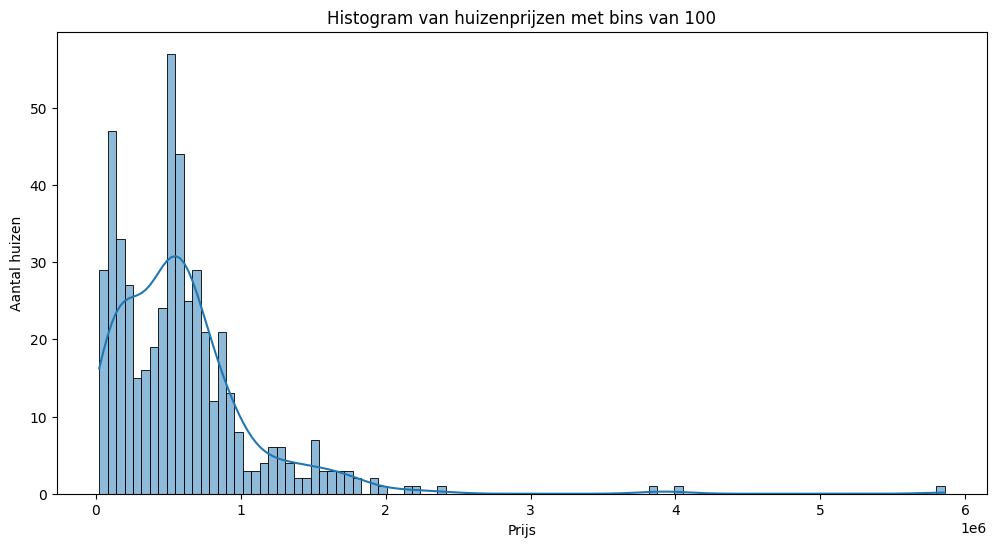

In [8]:
# Histogram van huizenprijzen met bins van 100
plt.figure(figsize=(12, 6))
sns.histplot(df["Price"], bins=100, kde=True)

plt.title("Histogram van huizenprijzen met bins van 100")
plt.xlabel("Prijs")
plt.ylabel("Aantal huizen")
plt.show()


We zien dat de grafiek rechts schuins (skewed) verdeeld is en dat er enkele extreme uitschieters zijn, dit kan veel effect hebben tijdens het modeleren en de data imbalanced maken.
We zullen ook een correlatie tabel maken om te bekijken of er lineare correlaties zichtbaar zijn 

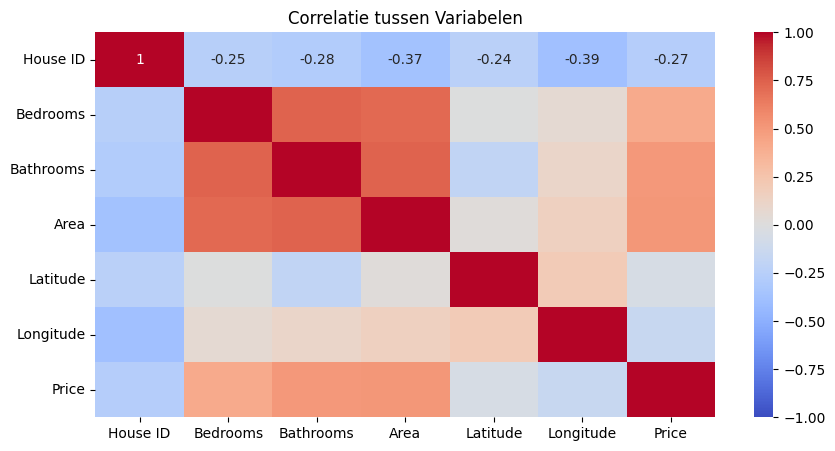

In [9]:
# Correlatie tussen variabelen
plt.figure(figsize=(10, 5))
sns.heatmap(df_tab.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlatie tussen Variabelen")
plt.show()

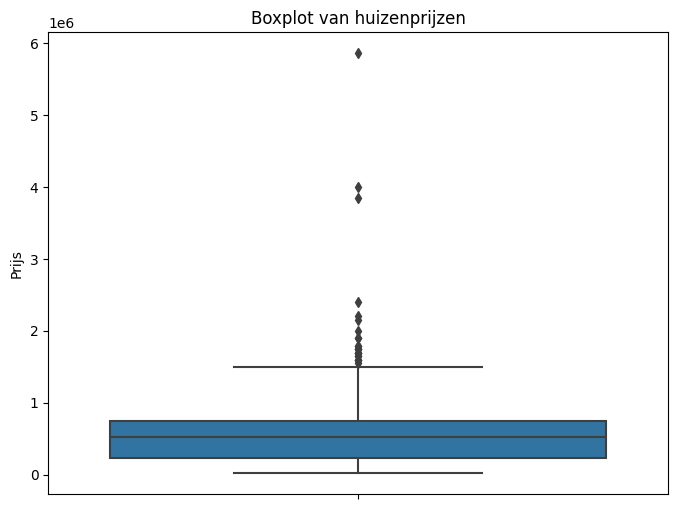

In [10]:
# Boxplot visualisatie van huizenprijzen
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_tab["Price"])
plt.title("Boxplot van huizenprijzen")
plt.ylabel("Prijs")
plt.show()

In de Boxlot zien we duidelijk dat er zeer positieve uitschieters zijn, dit kan duiden op hele duren woningen zoals villa's

# 1.3 ML model toepassen om meer inzicht in de data te krijgen

Om te bepalen welke kolommen bijdragen aan de prijs, zullen we een random forest regressor toepassen om de R2score te krijgen die de variantie verklaart en een MAPE score. We zullen ook proberen te achterhalen wat de feuture importance is om sterke variabelen te identificeren.

Fitting 3 folds for each of 108 candidates, totalling 324 fits


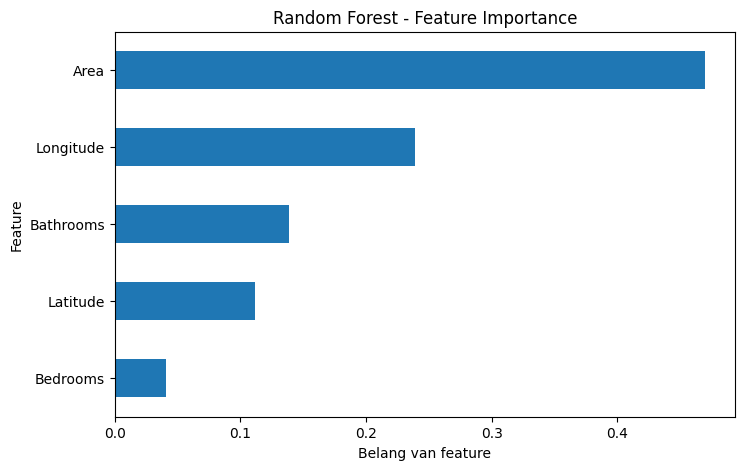

Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
R²-score: 0.8005764648977725
MAPE-score: 0.29397234057979604


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Laad de dataset
df = pd.read_csv("train.csv")  

# Features en target variabelen
X = df.drop(columns=["House ID", "Price"])  
y = df["Price"]

# Dataset splitten.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definieer het RandomForest-model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid parameters voor de tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearch 
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Train het model met hyperparameter tuning
grid_search.fit(X_train, y_train)

# Beste parameters en model zoeken
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Voorspellingen maken
y_pred_rf = best_model.predict(X_test)

# R²-score berekenen
r2_rf = r2_score(y_test, y_pred_rf)

# MAPE berekenen
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

# Feature importance berekenen
feature_importance_rf = pd.Series(best_model.feature_importances_, index=X.columns)

# Visualisatie van de feature importance
plt.figure(figsize=(8, 5))
feature_importance_rf.sort_values().plot(kind="barh", title="Random Forest - Feature Importance")
plt.xlabel("Belang van feature")
plt.ylabel("Feature")
plt.show()

# Printen resultaten
print("Beste hyperparameters:", best_params)
print("R²-score:", r2_rf)
print("MAPE-score:", mape_rf)

We zien dat het model 80% van de variantie kan verklaren en de mape score redelijk goed is ongeveer 30%.

We kunnen cocluderen uit de feature importance grafiek dat area longtidute en bathrooms de prijs flink beinvloeden. volgens onze random forest regressor model en hebben hierdoor een baseline kunnen vinden voor onze toekomstige evaluatie. 

# 2. Fully dense neural netwerk

### We zullen hieronder een fully dense neurale netwerk trainen die de prijs zal voorspellen, we maken gebruik van de MAPE score als benchmark.

Epoch 1/200


c:\Users\Shanil\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 628572.8125 - mape: 99.9994 - val_loss: 536189.9375 - val_mape: 99.9993
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 613098.0000 - mape: 99.9968 - val_loss: 536186.6875 - val_mape: 99.9978
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 580097.6250 - mape: 99.9910 - val_loss: 536176.7500 - val_mape: 99.9932
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 650954.5000 - mape: 99.9772 - val_loss: 536147.4375 - val_mape: 99.9800
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 603646.0000 - mape: 99.9407 - val_loss: 536069.6250 - val_mape: 99.9452
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 592792.9375 - mape: 99.8805 - val_loss: 535889.5000 - val_mape: 99.8647
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 646273.6875 - mape: 99.7441 - val_loss: 535530.3750 - val_mape: 99.7059
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 587107.0000 - mape: 99.5259 - val_lo

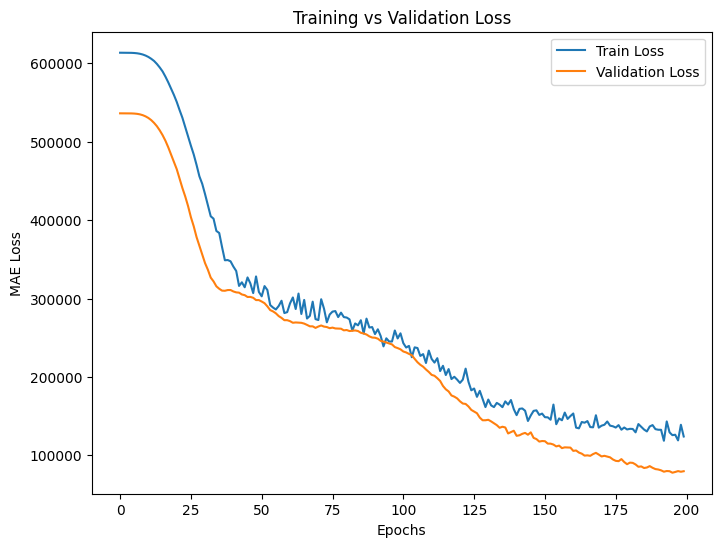

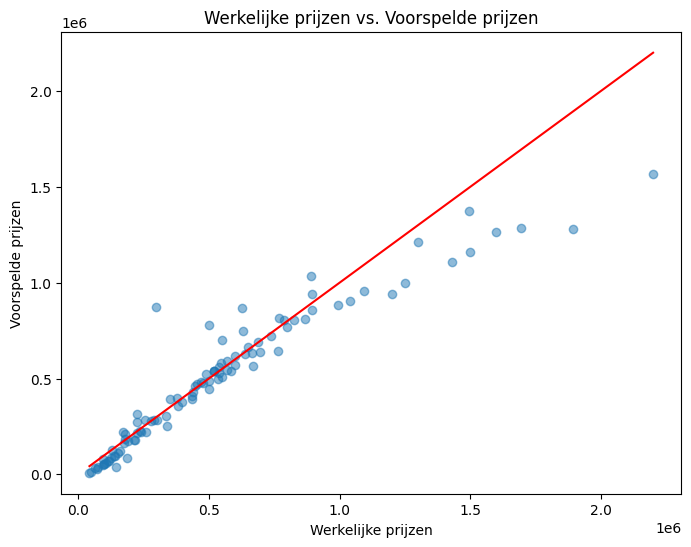

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# Laad de dataset
file_path = "train.csv"  
df = pd.read_csv(file_path)

# House ID-kolom deleten
df = df.drop(columns=["House ID"])

# Nieuwe features toevoegen
df["Rooms"] = df["Bedrooms"] + df["Bathrooms"]  # Totale kamers
df["Price_per_sqm"] = df["Price"] / df["Area"]  # Prijs per m²

# Drop de target-kolom (Price)
X = df.drop(columns=["Price"])
y = df["Price"]

# Splitten van training en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feuture scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelarchitectuur
model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  # Lineaire outputlaag
])

# Compilatie van het model met mae als lossfunctie en kleine learningrate van 0.0005
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mae", metrics=["mape"])

# meer epochs, kleinere batch size voor stabiliteit
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=1)

# Voorspellingen maken
y_pred = model.predict(X_test_scaled)

# MAPE score uitrekenen
mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape_score:.2%}")

# Loss functie plotten
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MAE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Werkelijke prijzen vs. Voorspelde prijzen plotten
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Werkelijke prijzen")
plt.ylabel("Voorspelde prijzen")
plt.title("Werkelijke prijzen vs. Voorspelde prijzen")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  
plt.show()

### We zien dat de loss en vall loss per epoch verder blijft dalen, onze MAPE score van ongeveer 0.2 is zeer goed. de kaggle score van dit model was 0.4


### Fully-connected neuraal netwerk
In deze code wordt een Dense Neural Network getraind om de huizen prijzen te voorspellen, enkel op basis van de tabulaire data. 
Een fully connected dense neural network is een type neuraal netwerk waarin elke neuron in een laag verbonden is met alle neuronen in de volgende laag. Dit zorgt ervoor dat alle informatie uit de vorige laag volledig beschikbaar is voor de volgende. Zo kan zo een model complexere verbanden leren.
Het netwerk bestaat uit een reeks lagen: een invoerlaag, een of meerdere verborgen lagen en een uitvoerlaag. In elke laag worden gewichten en biases toegepast om de doorgestuurde informatie te beïnvloeden. Er kan aan elke laag ook een activeringsfunctie worden toegevoegd. Met behulp hiervan kan bepaald worden welke signalen worden doorgegeven naar de volgende laag. Dit draagt bij een het herkennen van niet-lineaire verbanden.
Doordat zo een model erg oed getraind kan worden om patronen de herkennen, kan dit ook voor overfitting zorgen. Dit wordt voorkomen met bijvoorbeeld methoden zoals regularisatie en dropout.

Het model bestaat uit vier dense lagen:
De eerste laag is de invoerlaag met 128 neuronen en ReLu als activeringsfunctie. 
Vervolgens wordt er een batchnormalisatie-laag toegevoegd om de activaties te standaardiseren.
Dan nog een dense laag met 128 neuronen en ReLU.
Daarna een dropout-laag (30%) om overfitting te verminderen.
Dan een dense laag met 64 neuronen en ReLU.
En als laatste de uitvoerlaag met 1 neuron zonder activering (lineaire regressie).

Het aantal neuronen is gekozen om ervoor te zorgen dat het model voldoende complexe patronen in de data kan herkennen, zonder onnodig veel rekenkracht te verbruiken. Meer lagen en neuronen zouden kunnen leiden tot betere prestaties, maar verhogen ook het risico op overfitting.
Om zoveel mogelijk overfitting te tegen te gaan, is er een batchnormalisatielaag toegevoegd na de eerste laag en wordt dropout met een kans van 30% toegepast na de tweede laag. Hierdoor wordt minder gevoelig voor overfitting.

We hebben bij de tussenlagen gekozen voor ReLu als activeringsfunctie. Deze functie werkt namelijk snel en efficiënt bij diepe neurale netwerken. Andere mogelijke bekende activeringsfuncties zijn tanh of sigmoid, onze voorkeur is hier naar ReLU gegaan want het heeft het voordeel dat het de berekeningen eenvoudiger houdt en het risico op verzadiging van activaties beperkt. Hierdoor kan het model sneller en effectiever leren. De uitvoerlaag heeft natuurlijk geen activeringsfunctie nodig, aangezien het hier om regressie gaat. Een activeringsfunctie zoals sigmoid of softmax zou hier niet geschikt zijn, omdat deze alleen worden gebruikt voor classificatie.

Om het model te optimaliseren, gebruiken we de Adam-optimizer gekozen met een learning rate van 0.0005. Adam combineert de voordelen van momentum en RMSprop, waardoor het zowel stabiele als efficiënte updates maakt. De learning rate is best wel laag. Na wat verschillende learning rates geprobeerd te hebben, bleek deze waarde goed te werken om de loss te minimalizeren. Het aantal epochs (200) is gekozen op basis van een balans tussen underfitting en overfitting. Dit aantal geeft het model genoeg tijd om te trainen terwijl overfitting wordt voorkomen.

De gekozen lossfunctie is Mean Absolute Error (MAE), omdat deze minder gevoelig is voor outliers dan Mean Squared Error (MSE). MSE zou grote fouten zwaarder straffen, wat in sommige gevallen nuttig kan zijn, maar MAE is beter geschikt voor prijsvoorspellingen waar de absolute afwijking belangrijker is dan de kwadratische fout. Als evaluatiemetric is MAPE (Mean Absolute Percentage Error) gekozen, deze metric drukt de fout uit als percentage van de werkelijke waarde. 

Een cruciale stap in de preprocessing is het normaliseren van de invoerdata met StandardScaler. Dit zorgt ervoor dat elke feature een gemiddelde van 0 en een standaardafwijking van 1 heeft. Zonder deze stap zouden sommige features met grotere schaalwaarden (zoals oppervlakte of prijs) de training kunnen domineren, wat een negatieve invloed kan hebben op de prestaties van het model. 

GeeksforGeeks. (2024, 27 mei). What is Fully Connected Layer in Deep Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-fully-connected-layer-in-deep-learning/

Ayush. (2025, 10 maart). Optimizers in Deep Learning: A detailed guide. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

# 3. Convolutioneel neuraal netwerk from scratch

Afbeeldingen geladen: (500, 128, 128, 3)
Prijzen geladen: (500,)
Trainingsdata: (400, 128, 128, 3) (400,)
Validatiedata: (100, 128, 128, 3) (100,)


c:\Users\Shanil\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,183,105 (65.55 MB)

 Trainable params: 17,182,209 (65.54 MB)

 Non-trainable params: 896 (3.50 KB)

c:\Users\Shanil\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - loss: 590829.4375 - mape: 99.9588 - val_loss: 536171.2500 - val_mape: 99.9851
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 586358.3125 - mape: 99.2650 - val_loss: 535722.0625 - val_mape: 99.8062
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 637282.4375 - mape: 96.9403 - val_loss: 534120.7500 - val_mape: 99.1711
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - loss: 598960.8750 - mape: 90.9313 - val_loss: 529664.5000 - val_mape: 97.4119
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - loss: 522954.5312 - mape: 79.9554 - val_loss: 518104.7500 - val_mape: 92.8847
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - loss: 499975.7812 - mape: 72.0327 - val_loss: 495044.3125 - val_mape: 83.9369
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - loss: 448406.0625 - mape: 71.0090 - val_loss: 479083.0938 - val_mape: 78.4567
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - loss: 381554.0

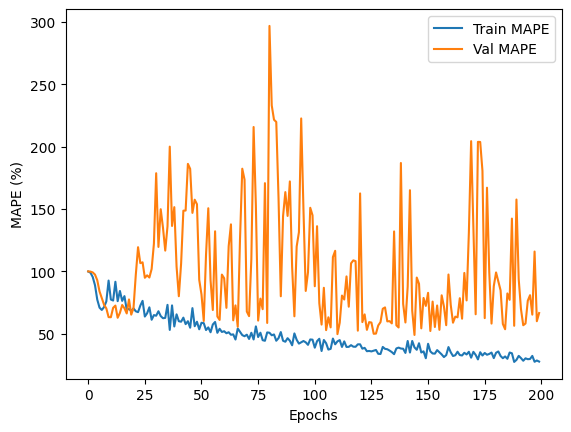

You must install pydot (`pip install pydot`) for `plot_model` to work.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


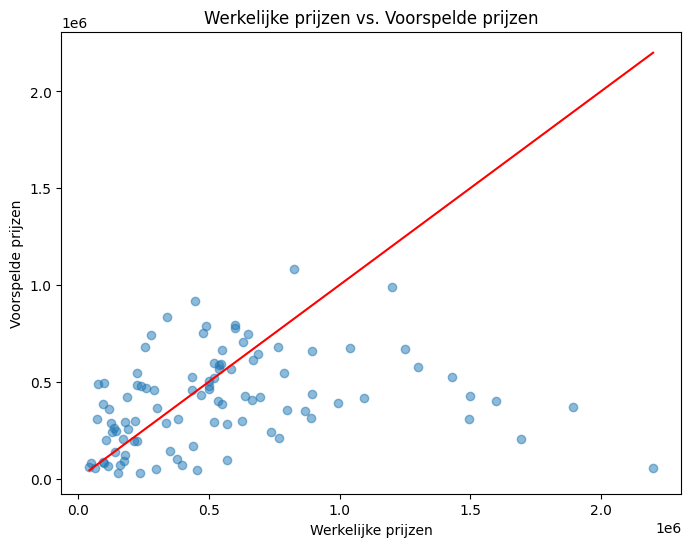

In [ ]:
#aad de data (Afbeeldingen + prijzen)
csv_data = pd.read_csv('train.csv')
prices = csv_data['Price'].values  

image_data = r"C:\Users\Shanil\Desktop\DL I\Train"
image_files = natsorted(os.listdir(image_data))

# Afbeeldingen inlezen en koppelen aan prijzen
image_size = (128, 128)
image_array = []

for image_file in image_files:  
    file_path = os.path.join(image_data, image_file)
    
    # Laad afbeelding en converteer naar numeriek formaat
    img = cv2.imread(file_path)
    img = cv2.resize(img, image_size)  # Resize naar vaste dimensies
    img = img / 255.0  # Normaliseer pixelwaarden tussen 0 en 1
    image_array.append(img)

# Converteer naar numpy arrays
X = np.array(image_array, dtype=np.float32)
y = np.array(prices, dtype=np.float32)  

print("Afbeeldingen geladen:", X.shape)
print("Prijzen geladen:", y.shape)

# splitten van train / test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Trainingsdata:", X_train.shape, y_train.shape)
print("Validatiedata:", X_val.shape, y_val.shape)

#  CNN-model opbouwen
def build_model():
    model = keras.Sequential([
        # Eerste convolutionele laag
        layers.Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Tweede convolutionele laag
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Derde convolutionele laag
        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Fully connected lagen
        layers.Flatten(),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.03)),  
        layers.Dropout(0.5), 
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="linear")  
    ])

    # Model compileren met MAE als loss en MAPE als metric
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="mae",  
        metrics=["mape"]  
    )

    return model

# Maak het model
model = build_model()
model.summary()

#  Data Augmentatie
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
)

# Pas augmentatie toe op de trainingsdata
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True) 

# Train het model
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32
)

# Model evalueren 
loss, mape = model.evaluate(X_val, y_val)
print(f"Validatie MAPE: {mape:.2f}%")

# Model prestaties visualiseren
plt.plot(history.history['mape'], label='Train MAPE')
plt.plot(history.history['val_mape'], label='Val MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE (%)')
plt.legend()
plt.show()

# Modelarchitectuur visualiseren 
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

# Voorspellingen maken 
y_pred = model.predict(X_val).flatten()  


# Scatter plot met werkelijke prijzen vs. voorspelde prijzen 
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Werkelijke prijzen")
plt.ylabel("Voorspelde prijzen")
plt.title("Werkelijke prijzen vs. Voorspelde prijzen")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  
plt.show()

### We zien dat de MAPE score slecht is 125% we hebben daarom besloten om dit model niet in kaggle te testen aangezien we niet onder de 50% daar zullen halen als onze MAPE score lokaal slecht is. in de werkelijke prijzen vs voorspelde prijzen zien we dat de voorspellings lijn (rode diagonale lijn) geen correlatie heeft met de datapunten.

opdracht 3: Convolutioneel netwerk
#### Onderbouw je keuzes van het aantal convolutionele lagen, poollagen, convolutionele kernels per laag, het aantal fully-connected lagen, het aantal neuronen per laag en het aantal epochs.
- Aantal Conv2D lagen is drie, omdat we overfitting willen voorkomen, maar nog wel voldoende feature-extractie willen hebben.
- Aantal MaxPooling2D lagen is drie, omdat we bij elke convo laag de computational complexiteit willen verminderen, wat voor efficiëntere training zorgt.
- Aantal kernels per Conv2D laag is 3x3, omdat de input_shape drie dimensionaal is, img_width, img_height en kleurkanalen.
- Het aantal fully-connected lagen is drie om underfitting te voorkomen.
- Het aantal epochs is 200, zodat het model niet te slecht presteert, maar ook niet te veel tijd gebruikt bij het trainen.
- Aantal neuronen/kernels per laag:
    - De eerste Conv2D laag heeft 64
    - De tweede Conv2D laag heeft 128
    - De derde Conv2D laag heeft 256
    - De eerste Dense laag heeft 256
    - De tweede Dense laag heeft 128
    Dit aantal is gekozen om het model complex genoeg te maken voor de afbeeldingen zonder dat er overfitting ontstaat.
    - De derde Dense laag heeft 1 neuroon, omdat dit de output laag is in een regressie CNN.

#### Gebruik een of meer van de volgende technieken in je model. Beschrijf en motiveer je keuze:
- L1 regularisatie: N.V.T, omdat L1 sparse weight vectors creëert wat niet geschikt is voor CNN's die juist veel feature-extractie nodig hebben.
- L2 regularisatie: We hebben L2 op de eerste dense layer toegepast, zodat het model stabieler wordt terwijl alle features gebruikt worden en alleen op één laag omdat het anders te zwaar wordt voor zowel de coëfficiënten als de train tijd.
- Dropout: Voor dit model hebben we dropout toegepast om, net zoals bij L2 regularisatie, overfitting te voorkomen en alleen op de dense layers, omdat dense layers gevoeliger zijn voor overfitting en veel parameters hebben.
- Batchnorm: We hebben Batchnorm toegepast om de activaties van de lagen te normaliseren, zodat het overfitting voorkomt en voor snellere training. We hebben dit op elke convolutionele laag toegepast voor de consistentie.

#### Beschrijf welke vormen van data augmentation (indien van toepassing) geschikt zijn voor dit probleem
Bij deze opdracht hebben we te maken met image detection en weinig data (alleen afbeeldingen en de prijs kolom), dus technieken zoals rotation range, height en width shift range en horizontal flip zijn hier handig om variaties in de data te creëren om zo extra data aan te maken, met de genoemde technieken kunnen we gedraaide afbeeldingen, lange afbeeldingen, brede afbeeldingen en gespiegelde afbeeldingen krijgen. Er is geen data augmentation op de val data toegepast, omdat deze data gebruikt moet worden voor vergelijkingen met de voorpelde waardes.

#### Bronnen:
ChatGPT: https://chatgpt.com/c/67e2a4be-24fc-800c-a775-9c01974403d6

L1 en L2: GeeksforGeeks. (2024, May 14). How does L1 and L2 regularization prevent overfitting? GeeksforGeeks. https://www.geeksforgeeks.org/how-does-l1-and-l2-regularization-prevent-overfitting/

Dropout: GeeksforGeeks. (2024a, March 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

Batch normalisatie: GeeksforGeeks. (2025, February 26). What is Batch Normalization In Deep Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-batch-normalization-in-deep-learning/

Data Augmentation: GeeksforGeeks. (2024c, July 22). What is Data Augmentation? How Does Data Augmentation Work for Images? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-data-augmentation-how-does-data-augmentation-work-for-images/

Max Pooling: GeeksforGeeks. (2025a, February 4). CNN | Introduction to pooling layer. GeeksforGeeks. https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

Kernel size: GeeksforGeeks. (2024, February 13). How to Choose Kernel Size in CNN? GeeksforGeeks. https://www.geeksforgeeks.org/how-to-choose-kernel-size-in-cnn/

# 4. Transfer learning

Model: "TransferLearning_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,877,988 (18.61 MB)

 Trainable params: 828,417 (3.16 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/30


c:\Users\Shanil\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - loss: 12.9598 - mean_absolute_error: 12.8274 - val_loss: 11.5172 - val_mean_absolute_error: 11.3866 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 11.2512 - mean_absolute_error: 11.1212 - val_loss: 8.9931 - val_mean_absolute_error: 8.8647 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 8.3419 - mean_absolute_error: 8.2141 - val_loss: 4.1528 - val_mean_absolute_error: 4.0265 - learning_rate: 1.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 3.2037 - mean_absolute_error: 3.0779 - val_loss: 2.2468 - val_mean_absolute_error: 2.1224 - learning_rate: 1.0000e-04
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 2.6045 - mean_absolute_error: 2.4806 - val_loss: 0.9252 - val_mean_absolute_error: 0.8030 - learning_rate: 1.0000e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 2.1790 - mean_absolute_error: 2.0573 - val_loss: 0.857

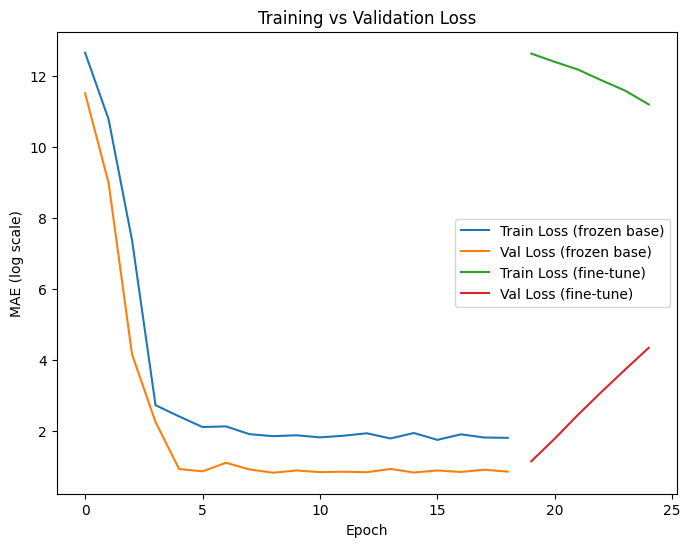

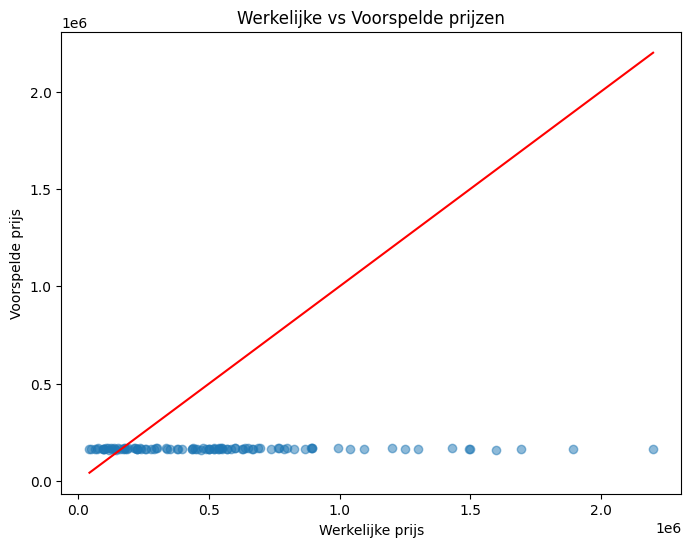


✅ MAPE op testdata (originele schaal): 65.05%


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from natsort import natsorted

#  Data inladen (CSV)
csv_file_path = r"train.csv"
df_prices = pd.read_csv(csv_file_path)
prices = df_prices["Price"].values

# Log-transform van de prijs (log(1 + y)).
y_log = np.log1p(prices)

# Afbeeldingen inladen 
image_folder = r"C:\Users\Shanil\Desktop\DL I\Train"
all_files = os.listdir(image_folder)
image_files = natsorted([f for f in all_files if f.endswith(".jpg")])

assert len(image_files) >= len(df_prices), (
    f"Er zijn minder jpg's ({len(image_files)}) dan rijen ({len(df_prices)})!"
)
image_files = image_files[: len(df_prices)]

images = []
for img_name in image_files:
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (160, 160))
    img = img[..., ::-1]  # BGR->RGB
    img = img / 255.0     # Normaliseren
    images.append(img)

X_images = np.array(images, dtype=np.float32)

# Train/test split 
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_images, y_log, test_size=0.2, random_state=42
)

#  Data Augmentatie 
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Vooraf getraind model EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(160, 160, 3)
)


# Bevries alle lagen van base_model (eerste trainingsfase) 
for layer in base_model.layers:
    layer.trainable = False

# L2 regularisatie gebruiken
l2_reg = regularizers.l2(1e-4)

inputs = keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    512,
    activation='relu',
    kernel_regularizer=l2_reg
)(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=l2_reg
)(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=l2_reg
)(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(
    64,
    activation='relu',
    kernel_regularizer=l2_reg
)(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation='linear')(x)  
model = Model(inputs, outputs, name="TransferLearning_EfficientNetB0")



#Compileer met een kleine learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

model.summary()

# Callbacks (EarlyStopping + ReduceLROnPlateau) 
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Train de Dense-top, terwijl base_model bevroren blijft =
history_top = model.fit(
    datagen.flow(X_train, y_train_log, batch_size=32),
    validation_data=(X_test, y_test_log),
    epochs=30,  
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


# Ontdooi de laatste 5 lagen van het base model
unfreeze_from = len(base_model.layers) - 5
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

#  nog kleinere learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

fine_tune_history = model.fit(
    datagen.flow(X_train, y_train_log, batch_size=32),
    validation_data=(X_test, y_test_log),
    epochs=15, 
    callbacks=[fine_tune_stop, reduce_lr],
    verbose=1
)

#  Evaluatie 
# Haal de voorspellingen (in log-schaal) op en zet ze terug naar de originele schaal
y_pred_log = model.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)   
y_test = np.expm1(y_test_log)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"\n✅ MAPE op testdata (originele schaal): {mape:.2f}%")

print("Min / Max in test set:", y_test.min(), y_test.max())

# Enkele voorspellingen vs werkelijkheid
import numpy as np
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
print("\n=== Enkele voorspellingen vs werkelijkheid ===")
for i in random_indices:
    print(f"Test idx {i} | Real: {y_test[i]:.0f} | Pred: {y_pred[i]:.0f}")

#  Plot loss (train vs val)
plt.figure(figsize=(8,6))

# Plot top-lagen training
plt.plot(history_top.history['loss'], label='Train Loss (frozen base)')
plt.plot(history_top.history['val_loss'], label='Val Loss (frozen base)')


if 'loss' in fine_tune_history.history:
    start_epoch_ft = len(history_top.history['loss'])
    ft_x = range(start_epoch_ft, start_epoch_ft + len(fine_tune_history.history['loss']))
    plt.plot(ft_x, fine_tune_history.history['loss'], label='Train Loss (fine-tune)')
    plt.plot(ft_x, fine_tune_history.history['val_loss'], label='Val Loss (fine-tune)')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE (log scale)')
plt.legend()
plt.show()

# Plot werkelijkheid vs voorspelling
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_price = min(y_test.min(), y_pred.min())
max_price = max(y_test.max(), y_pred.max())
plt.plot([min_price, max_price], [min_price, max_price], color='red')
plt.title('Werkelijke vs Voorspelde prijzen')
plt.xlabel('Werkelijke prijs')
plt.ylabel('Voorspelde prijs')
plt.show()


print(f"\n✅ MAPE op testdata (originele schaal): {mape:.2f}%")

Transfer learning is een techniek dat gebruik maakt van een vooraf getraind model om voorspellingen te maken. Dit kan generalisatie verbeteren, en is handig om computatiekosten te besparen en het trainingsproces te versnellen. Door een vooraf getraind model te hebben die getraind is op een grote dataset, hoeven wij minder tijd te besteden aan het trainen van een model, en hebben wij meer diversiteit in ons trainingdata. Wij gebruiken in dit geval het model EfficientNetB0 met ImageNet als data, dit dataset bevat 14 miljoen verschillende beelden. Dit model hebben we gekozen voor zijn accuraatheid met weinig computerkracht. (Restack, z.d.) (Bhupendra, 2023)

We zullen alle lagen van de vooraf getrainde EfficientNetB0 bevriezen tijdens de eerste trainingsfase. Dit betekent dat de gewichten van deze lagen niet zullen worden bijgewerkt. Dit is handig omdat de vooraf getrainde lagen al veel kennis hebben opgedaan over het herkennen van patronen in afbeeldingen. Door deze lagen te bevriezen, kunnen we voorkomen dat de gewichten worden verstoord en de prestaties van het model worden verminderd. (GeeksforGeeks, 2024)

In totaal, hebben wij 10 lagen toegevoegd aan het vooraf getraind model. Dat zijn 4 Dense layers, 4 Dropout layers, 1 GlobalAveragePooling2D layer en 1 output layer (Dense met lineair activatie). Als eerst heb je de pooling layer, dat helpt met het verminderen van hoeveelheid data die door de volgende layers gaat door het nemen van het gemiddelde over de lengte en breedte van de data. Daarna heb je een Dense layer, hier gaan de neutronen door bij het trainen met ReLU-activatie om complexe patronen te kunnen vinden. Bij de Dense layers heb je ook L2-regularisatie, dat helpt met het verminderen van overfitting door grote gewichten te penaliseren. Na de Dense layers heb je een Dropout layer die willekeurig 10% van de neuronen tijdens het trainen deactiveert om beter te kunnen generaliseren. Dit herhaalt een paar keer tot de output layer (Dense met lineair activatie). Dit output layer voorspelt een continu waarde, en lineair activatie zorgt ervoor dat er geen range voor de uitkomst is, dat is het tegenovergestelde van ReLU. (W&B, 2025) (GeeksforGeeks, 2024)

Wij maken naast de L2-regularisatie ook gebruik van data augmentatie. Dit zorgt ervoor dat we meer data hebben, waardoor overfitting vermindert. De foto’s vanuit ons dataset zijn heel erg verschillend, denk bijvoorbeeld aan de verlichting of gezichtspunt. Dit is niet altijd hetzelfde, dus is het handig om zoveel mogelijk data te hebben met deze verschillende variabelen om dit in het praktijk ook goed te voorspellen. (Amazon Web Services, z.d.)

Ook zullen we callbacks instellen om de training te monitoren en te stoppen als de prestaties niet verbeteren. We maken gebruik van EarlyStopping om de training te stoppen wanneer de loss niet meer verbetert en ReduceLROnPlateau om de learning rate te verlagen als de loss niet meer verbetert. Dit helpt om de training stabiel te houden en overfitting te voorkomen. (Mohanty, 2021)



GeeksforGeeks. (2024, 16 februari). What Are the Consequences of Not Freezing Layers in Transfer Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-are-the-consequences-of-not-freezing-layers-in-transfer-learning/

Mohanty, A. (2021, 14 december). Understanding callbacks in Keras - Analytics Vidhya - medium. Medium. https://medium.com/analytics-vidhya/understanding-callbacks-in-keras-98c935095219

Bhupendra. (2023, 15 maart). The Pros and Cons of Using Pre-Trained Models in Machine Learning. Medium. https://medium.com/@bhupendra360i/the-pros-and-cons-of-using-pre-trained-models-in-machine-learning-9bbd9e6802f

W&B. (2025, 30 maart). Weights & biases. W&B. https://wandb.ai/ayush-thakur/keras-dense/reports/Keras-Dense-Layer-How-to-Use-It-Correctly--Vmlldzo0MjAzNDY1

GeeksforGeeks. (2024, 31 januari). List of Deep Learning Layers. GeeksforGeeks. https://www.geeksforgeeks.org/ml-list-of-deep-learning-layers/

What is Data Augmentation? - Data Augmentation Techniques Explained - AWS. (z.d.). Amazon Web Services, Inc. https://aws.amazon.com/what-is/data-augmentation/

Restack. (z.d.). EfficientNet vs ResNet Comparison | Restackio. https://www.restack.io/p/vision-fine-tuning-answer-efficientnet-vs-resnet-cat-ai

# 5. Multimodaal model

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,226,500 (16.12 MB)

 Trainable params: 176,929 (691.13 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 0.7307 - mean_absolute_error: 0.7284 - val_loss: 0.5904 - val_mean_absolute_error: 0.5881 - learning_rate: 1.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - loss: 0.6549 - mean_absolute_error: 0.6526 - val_loss: 0.5793 - val_mean_absolute_error: 0.5769 - learning_rate: 1.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - loss: 0.7508 - mean_absolute_error: 0.7485 - val_loss: 0.5327 - val_mean_absolute_error: 0.5304 - learning_rate: 1.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.6546 - mean_absolute_error: 0.6523 - val_loss: 0.5012 - val_mean_absolute_error: 0.4989 - learning_rate: 1.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.6312 - mean_absolute_error: 0.6289 - val_loss: 0.4825 - val_mean_absolute_error: 0.4802 - learning_rate: 1.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.5436 - mean_absolute_error: 0.5413 - val_

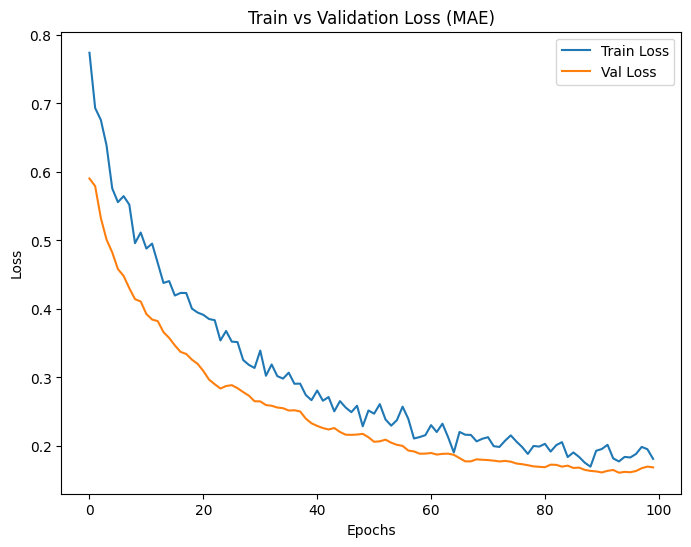

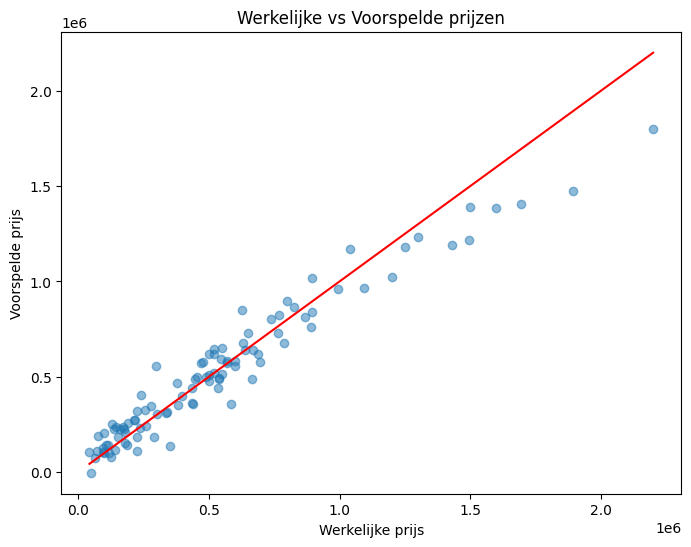

In [25]:
# Data inladen
csv_path = r"C:\Users\Shanil\Desktop\DL I\train.csv"
df = pd.read_csv(csv_path)

# Feature Engineering 
df["Rooms"] = df["Bedrooms"] + df["Bathrooms"]
df["Price_per_sqm"] = df["Price"] / df["Area"]

# Features & targets aanmaken
price = df["Price"].values.reshape(-1, 1)

tabular_features = df[[
    "Bedrooms", "Bathrooms", "Area",
    "Latitude", "Longitude", "Rooms", "Price_per_sqm"
]].values

# Schalen met standaardscaler
price_scaler = StandardScaler()
tabular_scaler = StandardScaler()

y_scaled = price_scaler.fit_transform(price)
X_tab_scaled = tabular_scaler.fit_transform(tabular_features)

# Afbeeldingen inladen 
image_folder = r"C:\Users\Shanil\Desktop\DL I\Train"
image_files = natsorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])[:len(df)]

images = []
for img_name in image_files:
    img = cv2.imread(os.path.join(image_folder, img_name))
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    images.append(img)

X_images = np.array(images, dtype=np.float32)

# Train/test split
X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_images, X_tab_scaled, y_scaled, test_size=0.2, random_state=42
)

# tf.data pipeline voor betere efficientie
train_dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_tab_train), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices(((X_img_test, X_tab_test), y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#   multimodaal model

# Tak 1: EfficientNet
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = layers.Dropout(0.3)(x)

# Tak 2: Tabular data van train.csv
tabular_input = Input(shape=(X_tab_scaled.shape[1],), name="tabular_input")
t = layers.Dense(64, activation='relu')(tabular_input)
t = layers.Dropout(0.2)(t)
t = layers.Dense(32, activation='relu')(t)

# Combinatie
combined = layers.concatenate([x, t])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
z = layers.Dense(1, activation='linear')(z)

model = Model(inputs=[image_input, tabular_input], outputs=z)

# Compilatie
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

plot_model(model, to_file="multimodaal_model.png", show_shapes=True, show_layer_names=True)
model.summary()

# Callback functies
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=8, verbose=1)

# Train het model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

#Evaluatie
y_pred_scaled = model.predict(val_dataset).flatten()
y_test_scaled = y_test.flatten()

y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = price_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\n✅ MAPE op testdata: {mape:.2%}")

#  Verliesplot 
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Voorspelling vs werkelijkheid 
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r')
plt.xlabel("Werkelijke prijs")
plt.ylabel("Voorspelde prijs")
plt.title("Werkelijke vs Voorspelde prijzen")
plt.show()


Dit model heeft een lokale MAPE score van 23% in Kaggle is dit 49%. Dit model presteerdt dus redelijk goed, als we naar de werkelijke vs voorspelde prijzen kijken zien we dat de datapunten relatief dicht bij onze diagonale voorspellingslijn liggen. dit betekent dat we een bruikbare model hebben.

een  multimodaal model combineert 2 input sources, in onze geval afbeeldingen en tabulaire data, we kunnen de afbeeldingen verwerken in een CNN waarbij we gebruik maken van een pre trained model EfficientNetB0. Dit model is al getrained om miljoenen beelden. Dee eerste lagen van onze (CNN) network zijn bevroren zodat ze niet opnieuw getrained worden, dit bespaart tijd en voorkomt overfitting.
Voor de tabulaire data maken we gebruik van ReLU activatie en dropout om overfitting te voorkomen. 
We maken 2 takken van de inputsources en combineren ze dan en laten een dense laag erop los om alle combinaties te leren, de finale laag Maakt de uiteindelijke voorspelling van de prijs (regressie).
Als Optimizer gebruiken we Adam met een lage learningrate van 1e-4 wat stabiel en snel is. We gebruiken ook early stopping om overfitting te voorkomen als onze model niet significante verbeteringen laat zien in de loss scores. 
Reduce on plateau verlaagt de leersnelheid automatisch als de validatie vastloopt.

Bronen: 
Medium. (3 september 2023) Multi-Modal Deep Learning: Combining Computer Vision and NLP for Enhanced AI: https://medium.com/@mubarak.k1919/multi-modal-deep-learning-combining-computer-vision-and-nlp-for-enhanced-ai-27ce6dda3a86


# 6. bevindingen

### 1.  onze fully-dense neurale netwerk hebben we een lokale score van 19.2% behaald. Op kaggle was dit 0.40291

### 2.voor onze CNN from scratch hebben wij een lokale score van 125% behaald, vanwege onze slechte score hebben we geen submission hirvan gedaan op kaggle, dit zou niet zinvol zijn.

### 3. Voor onze Transfer Learning model hebben we een lokale score van 65% behaald, angezien Kaggle de modellen strenger afstraft en de MAPE score structureel hoger ligt dan de lokale score, was het ook niet zinvol om voor dit model een kaggle submission in te dienen.

### 4. Voor onze laaste multimodale model hebben we een lokale score van 23% bereikt, dit was op Kaggle 0.49 wat net onder de grens was. Dit model presteerd dus redelijk goed maar wel slechter dan onze eerste model.

###  We zien dat onze eerste model het best presteert onder de volgende parameters: 
 layers.Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) 

    Met als optimizer Adam en een learning rate van 0.0005 ook maakten we hier gebruik van de MAE als loss functie

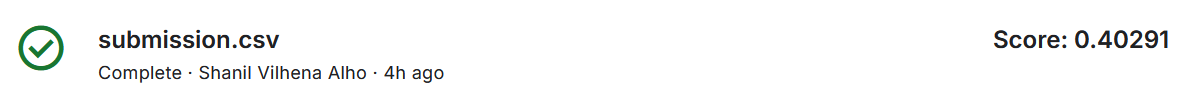 score van model 1 fully dense neural network


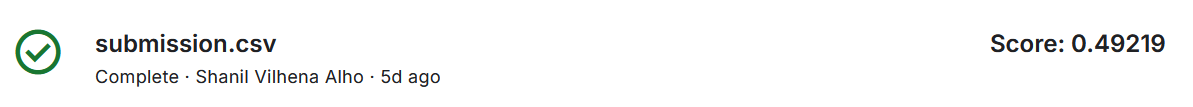 Score van model 4 multimodaal

# 7. 

Het moddeleringsproces was zeer uitdagend, we hebben te maken gekregen met huizen die buiten proportioneel duur waren waardoor onze modelen moeite hadden met het voorspellen van duren huizen e.g. boven de 1.000.000 USD. de gemiddelde huizen prijzen lagen tussen de 5 en 6 ton maar er waren meer dan 20% datapunten die waardes hadden tussen de 1.000.000 USD en 6.000.000 USD.

we hebben veel modellen moeten maken voordat we een MAPE score kregen wat aceptabel was, huisprijzen voorspellen met enkel afbeeldingen en prijzen als labels was zeer moeilijk, een MAPE score onder de 60% was voor ons niet mogelijk. op basis van enkel tabulaire data of afbeeldingen + tabulaire data kregen we wel MAPE scores onder de 50%

Ook hebben wij het vermoeden dat de kaggle test set relatief veel uitschieters qua prijzen heeft waardoor onze model op kaggle slechter presteert. 

We kunnen hieruit de conclusie trekken dat er meer informatie in de tabulaire data zat wat de prijzen van de uitschieters konden verklaren dan enkel de afbeeldingen, denk hierbij aan een voorbeeld dat een grote area betekent dat je waarschijnlijk een groot huis/villa hebt en de prijs hoger zal zijn.
Als je enkel op de afbeeldingen traint, dan heb je geen data zoals de grootte van een huis waardoor je voorspellingen inherent minder goed zullen zijn

wij kunnen als advies aan makelaars en verkopers  geven dat ons model goed gebruikt kan worden om normale huizen mee te taxeren. echter zal onze model slechter presteren bij duurdere woningen.

8. bronnenlijst:

GeeksforGeeks. (2024, 27 mei). What is Fully Connected Layer in Deep Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-fully-connected-layer-in-deep-learning/

Ayush. (2025, 10 maart). Optimizers in Deep Learning: A detailed guide. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

ChatGPT: https://chatgpt.com/c/67e2a4be-24fc-800c-a775-9c01974403d6

L1 en L2: GeeksforGeeks. (2024, May 14). How does L1 and L2 regularization prevent overfitting? GeeksforGeeks. https://www.geeksforgeeks.org/how-does-l1-and-l2-regularization-prevent-overfitting/

Dropout: GeeksforGeeks. (2024a, March 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

Batch normalisatie: GeeksforGeeks. (2025, February 26). What is Batch Normalization In Deep Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-batch-normalization-in-deep-learning/

Data Augmentation: GeeksforGeeks. (2024c, July 22). What is Data Augmentation? How Does Data Augmentation Work for Images? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-data-augmentation-how-does-data-augmentation-work-for-images/

Max Pooling: GeeksforGeeks. (2025a, February 4). CNN | Introduction to pooling layer. GeeksforGeeks. https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

Kernel size: GeeksforGeeks. (2024, February 13). How to Choose Kernel Size in CNN? GeeksforGeeks. https://www.geeksforgeeks.org/how-to-choose-kernel-size-in-cnn/


GeeksforGeeks. (2024, 16 februari). What Are the Consequences of Not Freezing Layers in Transfer Learning? GeeksforGeeks. https://www.geeksforgeeks.org/what-are-the-consequences-of-not-freezing-layers-in-transfer-learning/

Mohanty, A. (2021, 14 december). Understanding callbacks in Keras - Analytics Vidhya - medium. Medium. https://medium.com/analytics-vidhya/understanding-callbacks-in-keras-98c935095219

Bhupendra. (2023, 15 maart). The Pros and Cons of Using Pre-Trained Models in Machine Learning. Medium. https://medium.com/@bhupendra360i/the-pros-and-cons-of-using-pre-trained-models-in-machine-learning-9bbd9e6802f

W&B. (2025, 30 maart). Weights & biases. W&B. https://wandb.ai/ayush-thakur/keras-dense/reports/Keras-Dense-Layer-How-to-Use-It-Correctly--Vmlldzo0MjAzNDY1

GeeksforGeeks. (2024, 31 januari). List of Deep Learning Layers. GeeksforGeeks. https://www.geeksforgeeks.org/ml-list-of-deep-learning-layers/

What is Data Augmentation? - Data Augmentation Techniques Explained - AWS. (z.d.). Amazon Web Services, Inc. https://aws.amazon.com/what-is/data-augmentation/

Restack. (z.d.). EfficientNet vs ResNet Comparison | Restackio. https://www.restack.io/p/vision-fine-tuning-answer-efficientnet-vs-resnet-cat-ai

Medium. (3 september 2023) Multi-Modal Deep Learning: Combining Computer Vision and NLP for Enhanced AI: https://medium.com/@mubarak.k1919/multi-modal-deep-learning-combining-computer-vision-and-nlp-for-enhanced-ai-27ce6dda3a86
